In [1]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
results = pd.read_csv('activation_diff_results_inverse_transform.csv')

In [5]:
results = results[results["inverse_method"] == 'pseudo_inverse']

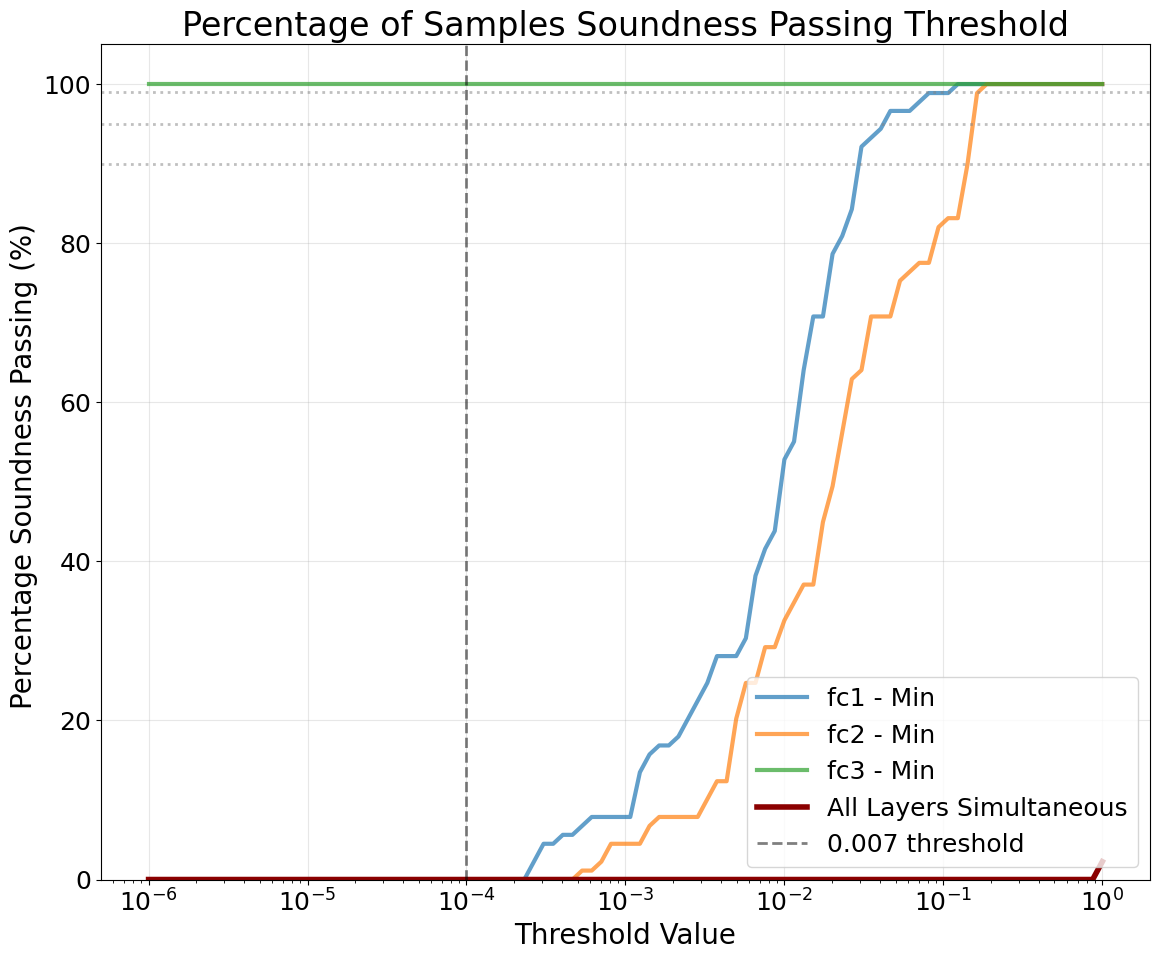

In [10]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set global font size
plt.rcParams.update({'font.size': 20})

# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1 (0.000001 to 1)

# Create single plot figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

layers = ['fc1', 'fc2', 'fc3']

# Plot minimum values for each layer
for layer in layers:
    column = f'{layer}_min_abs_diff'
    values = results[column].values
    
    # Calculate percentage passing each threshold
    percentages = []
    for threshold in thresholds:
        passing = np.sum(values <= threshold) / len(values) * 100
        percentages.append(passing)
    
    # Plot cumulative distribution
    ax.semilogx(thresholds, percentages, 
               label=f'{layer} - Min',
               linewidth=3, alpha=0.7)

# Plot the all-layers maximum (worst case - ALL must pass)
values = results['all_layers_max_diff'].values
percentages_all = []
for threshold in thresholds:
    passing = np.sum(values <= threshold) / len(values) * 100
    percentages_all.append(passing)

ax.semilogx(thresholds, percentages_all, 
           label='All Layers Simultaneous',
           color='darkred', linewidth=4)

# Add reference lines
ax.axvline(x=0.0001, color='black', linestyle='--', alpha=0.5, label='0.007 threshold', linewidth=2)
ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5, linewidth=2)

ax.set_xlabel('Threshold Value', fontsize=20)
ax.set_ylabel('Percentage Soundness Passing (%) ', fontsize=20)
ax.set_title('Percentage of Samples Soundness Passing Threshold', fontsize=24)
ax.legend(fontsize=18, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.savefig('cumulative_threshold_min_and_all_layers.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# %%
# Analysis and Visualization
successful_results = results_df[results_df['reconstruction_success'] == True]

if len(successful_results) > 0:
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Input reconstruction error by method
    plt.subplot(3, 3, 1)
    method_order = successful_results.groupby('method')['input_mae'].median().sort_values().index
    sns.boxplot(x='method', y='input_mae', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Input Reconstruction Error (MAE) by Method')
    plt.yscale('log')
    
    # 2. Output reconstruction error
    plt.subplot(3, 3, 2)
    sns.boxplot(x='method', y='output_mse', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Output Reconstruction Error (MSE) by Method')
    plt.yscale('log')
    
    # 3. Prediction accuracy
    plt.subplot(3, 3, 3)
    pred_accuracy = successful_results.groupby('method')['same_prediction'].mean()
    plt.bar(pred_accuracy.index, pred_accuracy.values)
    plt.xticks(rotation=45)
    plt.title('Prediction Preservation Rate')
    plt.ylabel('Rate')
    
    # 4-6. Layer-wise reconstruction errors
    for idx, layer in enumerate(['fc1', 'fc2', 'fc3'], 4):
        plt.subplot(3, 3, idx)
        if f'{layer}_mse' in successful_results.columns:
            sns.boxplot(x='method', y=f'{layer}_mse', data=successful_results, order=method_order)
            plt.xticks(rotation=45)
            plt.title(f'{layer} Reconstruction Error')
            plt.yscale('log')
    
    # 7. Success rate by method
    plt.subplot(3, 3, 7)
    success_rate = results_df.groupby('method')['reconstruction_success'].mean()
    plt.bar(success_rate.index, success_rate.values)
    plt.xticks(rotation=45)
    plt.title('Reconstruction Success Rate')
    plt.ylabel('Success Rate')
    
    # 8. Cosine similarity distribution
    plt.subplot(3, 3, 8)
    for method in method_order:
        method_data = successful_results[successful_results['method'] == method]['input_cosine_sim']
        plt.hist(method_data, alpha=0.5, label=method, bins=20)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Input Space Cosine Similarity')
    
    # 9. Overall quality score
    plt.subplot(3, 3, 9)
    # Calculate composite score (lower is better)
    successful_results['quality_score'] = (
        successful_results['input_mae'] * 0.3 +
        successful_results['output_mse'] * 0.3 +
        (1 - successful_results['same_prediction']) * 0.4
    )
    sns.boxplot(x='method', y='quality_score', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Overall Reconstruction Quality (lower is better)')
    
    plt.tight_layout()
    plt.savefig('reconstruction_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("RECONSTRUCTION METHOD COMPARISON SUMMARY")
    print("="*80)
    
    for method in method_order:
        method_data = successful_results[successful_results['method'] == method]
        if len(method_data) > 0:
            print(f"\n{method.upper()}:")
            print(f"  Success Rate: {results_df[results_df['method'] == method]['reconstruction_success'].mean():.3f}")
            print(f"  Input MAE: {method_data['input_mae'].mean():.6f} ± {method_data['input_mae'].std():.6f}")
            print(f"  Output MSE: {method_data['output_mse'].mean():.6f} ± {method_data['output_mse'].std():.6f}")
            print(f"  Prediction Preservation: {method_data['same_prediction'].mean():.3f}")
            print(f"  Cosine Similarity: {method_data['input_cosine_sim'].mean():.3f} ± {method_data['input_cosine_sim'].std():.3f}")

    # Best method analysis
    print("\n" + "="*80)
    print("BEST METHOD BY METRIC:")
    print("="*80)
    
    metrics_to_minimize = ['input_mae', 'input_mse', 'output_mse', 'fc1_mse', 'fc2_mse', 'fc3_mse']
    metrics_to_maximize = ['input_cosine_sim', 'same_prediction']
    
    for metric in metrics_to_minimize:
        if metric in successful_results.columns:
            best_method = successful_results.groupby('method')[metric].mean().idxmin()
            best_value = successful_results.groupby('method')[metric].mean().min()
            print(f"  Best {metric}: {best_method} ({best_value:.6f})")
    
    for metric in metrics_to_maximize:
        if metric in successful_results.columns:
            best_method = successful_results.groupby('method')[metric].mean().idxmax()
            best_value = successful_results.groupby('method')[metric].mean().max()
            print(f"  Best {metric}: {best_method} ({best_value:.6f})")






